# Modelo para dados do Punk API

<a href="https://colab.research.google.com/github/ggarciabas/mlops_aws_punkapi/blob/master/notebooks/Modelagem.ipynb" target="_parent"><img src="https://img.shields.io/badge/Colab-Google?style=for-the-badge&labelColor=white&color=orange&logo=googlecolab" alt="Open In Colab"/></a>

In [ ]:
! pip install --upgrade pandas pandas_profiling vtreat biokit xgboost lightgbm shap
# atualiza pacotes para compatibilidade pandas e Pprofiling, instala vtreat

## Leitura dos dados iniciais

In [ ]:
import requests
import json
import pandas as pd

In [ ]:
# Schema definido pela Tabela Glue
tipo_schema = {'id': 'int', 
                'name': 'str', 
                'abv': 'double', 
                'ibu': 'int',
                'target_fg': 'int',
                'target_og': 'int',
                'ebc': 'double',
                'srm': 'double',
                'ph': 'double',
                'ebc_color':'int',
                'srm_color':'int'
               }

In [ ]:
# Cria Dataframe inicial para armazenar as bebidas
url='https://drive.google.com/file/d/1FPcnS0vh0SGBRDdkiGDZCc3l_nx2zC1K/view?usp=sharing' # amostra 1000/1500 ibus
url2='https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
# https://stackoverflow.com/questions/56611698/pandas-how-to-read-csv-file-from-google-drive-public
pd_beers = pd.read_json(url2)

In [ ]:
pd_beers[:2]

id  ...          contributed_by
0   49  ...  Sam Mason <samjbmason>
1  158  ...  Sam Mason <samjbmason>

[2 rows x 21 columns]

In [ ]:
pd_beers.dtypes

id                     int64
name                  object
tagline               object
first_brewed          object
description           object
image_url             object
abv                  float64
ibu                  float64
target_fg            float64
target_og            float64
ebc                  float64
srm                  float64
ph                   float64
attenuation_level    float64
volume                object
boil_volume           object
method                object
ingredients           object
food_pairing          object
brewers_tips          object
contributed_by        object
dtype: object

In [ ]:
pd_beers.count()

id                   2500
name                 2500
tagline              2500
first_brewed         2500
description          2500
image_url            2056
abv                  2500
ibu                  2477
target_fg            2495
target_og            2495
ebc                  2452
srm                  2452
ph                   2486
attenuation_level    2495
volume               2500
boil_volume          2500
method               2500
ingredients          2500
food_pairing         2500
brewers_tips         2500
contributed_by       2500
dtype: int64

## Limpa e organiza base para análises

- International Bitterness Unit (IBU): potencial de amargor
- Alcohol By Volume (ABV): porcentagem de álcool
  > $𝐴𝐵𝑉=(𝑂𝐺−𝐹𝐺)∗131,25$
  - Original Gravity (OG): densidade antes do processo
  - Final Gravity (FG): densidado após proceddo
- Standard Reference Method (SRM): coloração
- European Brewery Convention (EBC): coloração
- pH da água

In [ ]:
# Filtra colunas de interesse para a criação do modelo
features = ['abv', 'target_fg', 'target_og', 'ebc', 'srm', 'ph']
target = 'ibu'
cols = features+[target]

In [ ]:
# Remove registros duplicados da chamada a API (random)
pd_beers_clean = pd_beers[cols+['id']].drop_duplicates()

In [ ]:
pd_beers_clean = pd_beers[cols].reindex()

In [ ]:
# A métrica é relacionada à àgua (> 1000)
# pd_beers_clean['target_fg'] = pd_beers_clean['target_fg']-1000
# pd_beers_clean['target_og'] = pd_beers_clean['target_og']-1000

In [ ]:
# Registros únicos válidos
pd_beers_clean[target].notna().sum()

2477

In [ ]:
# Remove informações sem dados na coluna target
pd_beers_clean = pd_beers_clean[pd_beers_clean[target].notna()]

In [ ]:
# Ceveja clara ou escura
# pd_beers_clean['ebc_color'] = pd_beers_clean['ebc'].apply(lambda x: (1 if x<20 else 0) if x else -1)
# pd_beers_clean['srm_color'] = pd_beers_clean['srm'].apply(lambda x: (1 if x<12 else 0)  if x else -1 )

In [ ]:
pd_beers_clean[:4]

abv  target_fg  target_og   ebc   srm   ph    ibu
0  10.0     1016.0     1094.0  20.0  10.0  4.4   30.0
1   6.4     1012.0     1061.0  20.0  10.0  4.4   50.0
2   9.2     1085.0     1016.0  78.8  40.0  4.2   50.0
3   9.7     1015.0     1088.0  30.0  15.3  4.4  100.0

In [ ]:
pd_beers_clean.count()

abv          2477
target_fg    2477
target_og    2477
ebc          2440
srm          2440
ph           2468
ibu          2477
dtype: int64

In [ ]:
pd_beers_clean.columns

Index(['abv', 'target_fg', 'target_og', 'ebc', 'srm', 'ph', 'ibu'], dtype='object')

In [ ]:
# Variação das features
pd_beers_clean.max() - pd_beers_clean.min()

abv            40.5
target_fg     125.0
target_og     150.0
ebc           598.0
srm           304.0
ph             75.8
ibu          1157.0
dtype: float64

In [ ]:
len(pd_beers_clean['ibu'].unique())

53

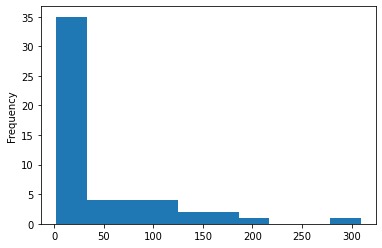

In [ ]:
pd_beers_clean.groupby("ibu").ibu.count().plot(kind='hist')

### Distribuição dos valores

[Pandas profiling](https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/)






In [ ]:
from pandas_profiling import ProfileReport

In [ ]:
def plot_profile (pdf):
  return ProfileReport(pdf)

In [ ]:
plot_profile(pd_beers_clean[cols])

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

> Variáveis com alta correlação EBC e SRM.

- IBU possui 53 valores distintos. 
- 50% dos dados estão entre 35 e 70.
- Valor mínimo é zero e máximo 1157.

### Correlação



In [ ]:
from biokit.viz import corrplot

Creating directory /root/.config/biokit 
Creating directory /root/.config/bioservices 


In [ ]:
def plot_correlacao (pdf):
  df_corr = pdf.corr()
  c = corrplot.Corrplot(df_corr)
  c.plot(colorbar=False, method='square', shrink=.9 ,rotation=45)

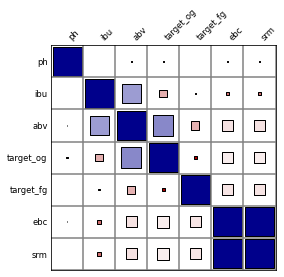

In [ ]:
plot_correlacao(pd_beers_clean)

> IBU apresenta uma correlação boa com ABV.

- Remover EBC ou SRM
- Remover ebc_color ou srm_color
> Alta correlação entre as informações (redundância)



## Machine Learning Model

1. [Machine learning: classification and regression](https://training.galaxyproject.org/training-material/topics/statistics/tutorials/classification_regression/tutorial.html#regression)
1. [Regression Metrics for Machine Learning](https://machinelearningmastery.com/regression-metrics-for-machine-learning/)
1. [Os Três Tipos de Aprendizado de Máquina](https://lamfo-unb.github.io/2017/07/27/tres-tipos-am/)
1. [Um Olhar Descontraído Sobre o Dilema Viés-Variância](https://lamfo-unb.github.io/2017/04/29/Um-Olhar-Descontraido-Sobre-o-Dilema-Vies-Variancia/)
1. [Regressão Logística](https://lamfo-unb.github.io/2020/04/30/Regress%C3%A3o-Log%C3%ADstica/)
1. [Why Data Normalization is necessary for Machine Learning models](https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029)
1. [Model Tuning (Part 1 - Train/Test Split)](https://dziganto.github.io/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-Train-Test-Split/)
1. [What is Regression? | SSE, SSR, SST | R-squared | Errors (ε vs. e)](https://www.youtube.com/watch?v=aq8VU5KLmkY)
1. [Regression II - Degrees of Freedom EXPLAINED | Adjusted R-Squared](https://www.youtube.com/watch?v=4otEcA3gjLk)
1. [Model Tuning (Part 2 - Validation & Cross-Validation)](https://dziganto.github.io/cross-validation/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-with-Validation-and-Cross-Validation/)

In [ ]:
from sklearn import model_selection, preprocessing, linear_model, metrics
import numpy as np

In [ ]:
import xgboost
print(xgboost.__version__)

1.4.2


In [ ]:
import lightgbm
print(lightgbm.__version__)

3.2.1


### Regressão anotações



> Regression predictive modeling is the task of approximating a mapping function (f) from input variables (X) to a continuous output variable (y). [2]

> The skill or performance of a regression model must be reported as an error in those predictions. [2]

**Metricas**
- Mean Squared Error (MSE).
  > $MSE =  \frac{\sum_{i}ˆN \left(y_i – yˆ_i\right)^2}{N}$\
  > A raiz remove o sinal da diferença e também infla as diferenças grandes.\
  > Como função de perda o MSE pune o modelo por grandes diferenças.\
  > Como métrica esta pune o modelo inflando o score do erro.
- Root Mean Squared Error (RMSE).
- Mean Absolute Error (MAE)
- Others [Sklearn Regression metrics](https://scikit-learn.org/stable/modules/classes.html#regression-metrics)


[XGBoost for Regression](https://machinelearningmastery.com/xgboost-for-regression/)
  - Execution speed and model performance.
  > XGBoost became the go-to method.\
  > Gradient boosting refers to a class of ensemble machine learning algorithms that can be used for classification or regression predictive modeling problems.\
  > Ensembles are constructed from decision tree models. Trees are added one at a time to the ensemble and fit to correct the prediction errors made by prior models. This is a type of ensemble machine learning model referred to as boosting.

### Dados para modelo

In [ ]:
b_feat = ['abv', 'target_fg', 'target_og', 'ebc', 'ph', 'srm'] 
b_target = 'ibu'
b_cols = b_feat+[b_target]
b_schema = {k:tipo_schema[k] for k in b_cols}

In [ ]:
baseline = pd_beers_clean[b_cols]

#### Nulos

In [ ]:
baseline.mean()

abv             7.789621
target_fg    1015.639080
target_og    1067.427210
ebc            68.724098
ph              4.651864
srm            34.669102
ibu            66.119499
dtype: float64

In [ ]:
baseline = baseline.fillna(baseline.mean()) # utilizado pelo v-treat

#### Schema

In [ ]:
baseline = baseline.astype(dtype=b_schema)
baseline.dtypes

abv          float64
target_fg      int64
target_og      int64
ebc          float64
ph           float64
srm          float64
ibu            int64
dtype: object

In [ ]:
baseline[:3]

abv  target_fg  target_og   ebc   ph   srm  ibu
0  10.0       1016       1094  20.0  4.4  10.0   30
1   6.4       1012       1061  20.0  4.4  10.0   50
2   9.2       1085       1016  78.8  4.2  40.0   50

#### Treino e Teste

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
B_interm, B_test = train_test_split(baseline, test_size=0.20, random_state=42) # --/20
B_train, B_valid = train_test_split(B_interm, test_size=0.20, random_state=42) # 60/20

### Avalia Modelos

[CatBoost vs. Light GBM vs. XGBoost](https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db)

#### Funções

In [ ]:
# MAE scores increase linearly with increases in error.
# A perfect mean absolute error value is 0.0, which means that all predictions matched the expected values exactly.
def evaluate_mae_model (model, X, y):
  cv_sc = 'neg_mean_absolute_error'
  cv = model_selection.RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = model_selection.cross_val_score(model, X, y, scoring=cv_sc, cv=cv, n_jobs=-1)
  scores = np.absolute(scores)
  print(f"Mean MAE: {scores.mean()} ({scores.std()}) [{scores.min()}, {scores.max()}]") # mean absolute error

In [ ]:
# R-squared is the percentage of the dependent variable variation that a linear model explains.
# 0% represents a model that does not explain any of the variation in the response variable around its mean.
def evaluate_r2_model (model, X, y):
  cv_sc = 'r2'
  cv = model_selection.RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = model_selection.cross_val_score(model, X, y, scoring=cv_sc, cv=cv, n_jobs=-1)
  print(f"R^2: {scores.mean()} ({scores.std()}) [{scores.min()}, {scores.max()}]") # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score

In [ ]:
# A perfect RMSE value is 0.0, which means that all predictions matched the expected values exactly.
# inflate high errors, punish larger errors more than smaller errors
def evaluate_rmse_model (model, X, y):
  cv_sc = 'neg_root_mean_squared_error'
  cv = model_selection.RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = model_selection.cross_val_score(model, X, y, scoring=cv_sc, cv=cv, n_jobs=-1)
  scores = np.absolute(scores)
  print(f"RMSE: {scores.mean()} ({scores.std()}) [{scores.min()}, {scores.max()}]") # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score

In [ ]:
def calc_r2_rmse(X, y, model):
    '''returns the R^2 and RMSE; assumes model already fit.'''
    predictions = model.predict(X)
    mse = metrics.mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    return model.score(X, y), rmse
# Ref: https://dziganto.github.io/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-Train-Test-Split/

In [ ]:
def avalia_ISE_OSE (X, y, X_t, y_t, model, to_print=True):
  # ISE
  if to_print:
    print ("ISE")
  r2_t, rmse_t = calc_r2_rmse(X, y, model)
  if to_print:
    print ("\tR^2 %.3f \tRMSE %.3f " % (r2_t, rmse_t))

  # OSE
  if to_print:
    print ("OSE")
  r2_v, rmse_v = calc_r2_rmse(X_t, y_t, model)
  if to_print:
    print ("\tR^2 %.3f \tRMSE %.3f " % (r2_v, rmse_v))

  if to_print:
    print (f"\nTest/Train {rmse_v/rmse_t} -> {((rmse_v/rmse_t)-1)*100} %")

  return (r2_t, rmse_t, r2_v, rmse_v)

#### Regressão linear

In [ ]:
lr = linear_model.LinearRegression(fit_intercept=True)
# Scores (10 k-fold)
evaluate_r2_model(lr, baseline[b_feat], baseline[b_target])
evaluate_rmse_model(lr, baseline[b_feat], baseline[b_target])
evaluate_mae_model(lr, baseline[b_feat], baseline[b_target])

R^2: 0.36745161719413466 (0.5372263706820315) [-1.3650966347236246, 0.7532360234619069]
RMSE: 63.44043227616346 (10.856031858837314) [44.38527617448817, 88.93214550431465]
Mean MAE: 33.88858028678654 (2.8559807018577006) [29.088519725215736, 39.7091021171387]


In [ ]:
lr = linear_model.LinearRegression(fit_intercept=True)
lr.fit(B_train[b_feat], B_train[b_target])
avalia_ISE_OSE(B_train[b_feat], B_train[b_target], B_valid[b_feat], B_valid[b_target], lr)

ISE
	R^2 0.528 	RMSE 66.923 
OSE
	R^2 0.587 	RMSE 64.493 

Test/Train 0.9637018218490643 -> -3.6298178150935723 %


(0.5278220630449477, 66.92257418112706, 0.5870481823755235, 64.4934066611813)

#### LightGBM

https://lightgbm.readthedocs.io/en/latest/

In [ ]:
lgbm = lightgbm.LGBMRegressor()
# Scores
evaluate_r2_model(lgbm, baseline[b_feat], baseline[b_target])
evaluate_rmse_model(lgbm, baseline[b_feat], baseline[b_target])
evaluate_mae_model(lgbm, baseline[b_feat], baseline[b_target])

R^2: 0.9381183749364114 (0.07358532740333375) [0.6508318533590673, 0.9902418003600609]
RMSE: 18.225537736131265 (4.651687664822163) [10.314777519496914, 33.11032643885993]
Mean MAE: 5.612021423243378 (1.0515061511162331) [4.152508166956617, 9.149196747306291]


In [ ]:
lgbm = lightgbm.LGBMRegressor()
lgbm.fit(B_train[b_feat], B_train[b_target])

avalia_ISE_OSE(B_train[b_feat], B_train[b_target], B_valid[b_feat], B_valid[b_target], lgbm)

ISE
	R^2 0.929 	RMSE 25.885 
OSE
	R^2 0.914 	RMSE 29.365 

Test/Train 1.1344662185980703 -> 13.446621859807028 %


(0.9293605465268607, 25.884719188032346, 0.9143871807416618, 29.36533949671997)

In [ ]:
evaluate_rmse_model(lgbm, B_test[b_feat], B_test[b_target])

RMSE: 65.6977788515547 (38.53911992402608) [27.897057535692337, 175.9790115177193]


In [ ]:
evaluate_r2_model(lgbm, B_test[b_feat], B_test[b_target])

R^2: -0.4569023797074481 (1.4356821541091764) [-5.830494673630586, 0.8222134695437633]


##### Interpretação do modelo

In [ ]:
lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

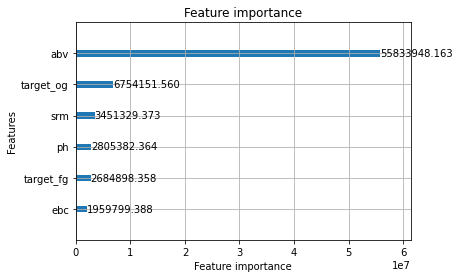

In [ ]:
lightgbm.plot_importance(lgbm, importance_type='gain')
# If "gain", result contains total gains of splits which use the feature.

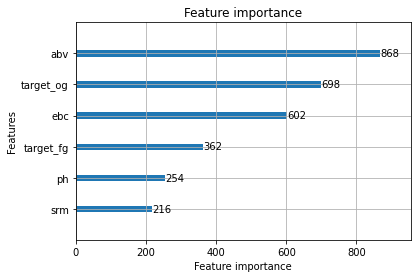

In [ ]:
lightgbm.plot_importance(lgbm, importance_type='split')
# If "split", result contains numbers of times the feature is used in a model.

-------------------
-------------------

#### XGBoost

- https://xgboost.readthedocs.io/en/latest/tutorials/model.html
- https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

##### ISE OSE

In [ ]:
xgb = xgboost.XGBRegressor()
# Scores
evaluate_r2_model(xgb, baseline[b_feat], baseline[b_target])
evaluate_rmse_model(xgb, baseline[b_feat], baseline[b_target])
evaluate_mae_model(xgb, baseline[b_feat], baseline[b_target])

R^2: 0.9976202006342785 (0.010786853820223399) [0.9395853549403343, 0.9999965296701065]
RMSE: 1.6355725913738501 (1.2038394172932665) [0.1886132208305212, 7.093908714219916]
Mean MAE: 0.28732662669311104 (0.1428623930630212) [0.10007287033142583, 0.9097167618813053]


In [ ]:
xgb = xgboost.XGBRegressor()
xgb.fit(B_train[b_feat], B_train[b_target])

avalia_ISE_OSE(B_train[b_feat], B_train[b_target], B_valid[b_feat], B_valid[b_target], xgb)

ISE
	R^2 1.000 	RMSE 1.497 
OSE
	R^2 1.000 	RMSE 1.494 

Test/Train 0.9985294924906143 -> -0.147050750938571 %


(0.9997638883849018,
 1.4965060213120838,
 0.9997783092988134,
 1.4943053979699035)

In [ ]:
evaluate_rmse_model(xgb, B_test[b_feat], B_test[b_target])

RMSE: 13.089273527609658 (7.096883875472736) [5.751763138130347, 32.60292040832483]


In [ ]:
evaluate_r2_model(xgb, B_test[b_feat], B_test[b_target])

R^2: 0.8748445349303847 (0.21513809464268907) [0.027346386500376796, 0.9994129586449094]


###### Parâmetros

In [ ]:
xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 2,
 'num_parallel_tree': 1,
 'objective': 'reg:squarederror',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

##### Interpretação do modelo

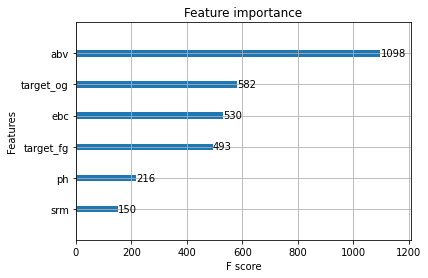

In [ ]:
xgboost.plot_importance(xgb, importance_type='weight') 
# "weight" is the number of times a feature appears in a tree

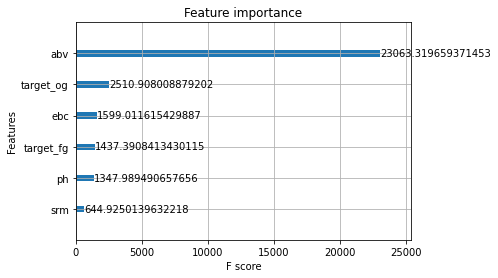

In [ ]:
xgboost.plot_importance(xgb, importance_type='gain') 
# "gain" is the average gain of splits which use the feature

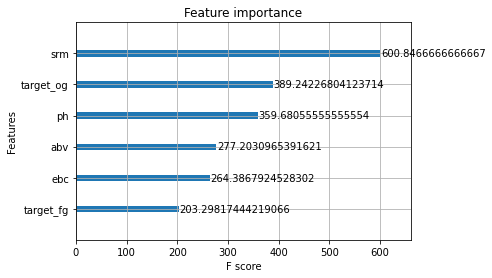

In [ ]:
xgboost.plot_importance(xgb, importance_type='cover') 
# "cover" is the average coverage of splits which use the feature where 
#     coverage is defined as the number of samples affected by the split

###### Shap
> SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. 

https://github.com/slundberg/shap

In [ ]:
import shap

# explain the model's predictions using SHAP
explainer = shap.Explainer(xgb)

In [ ]:
baseline.where(baseline.abv>20).describe()

abv    target_fg    target_og  ...    ph         srm          ibu
count  19.000000    19.000000    19.000000  ...  19.0   19.000000    19.000000
mean   36.263158  1022.315789  1122.894737  ...   4.4   76.315789  1122.894737
std     4.616903     6.155870    36.935221  ...   0.0   54.889842    36.935221
min    32.000000  1016.000000  1085.000000  ...   4.4   20.000000  1085.000000
25%    32.000000  1016.000000  1085.000000  ...   4.4   20.000000  1085.000000
50%    32.000000  1028.000000  1157.000000  ...   4.4  127.000000  1157.000000
75%    41.000000  1028.000000  1157.000000  ...   4.4  127.000000  1157.000000
max    41.000000  1028.000000  1157.000000  ...   4.4  127.000000  1157.000000

[8 rows x 7 columns]

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


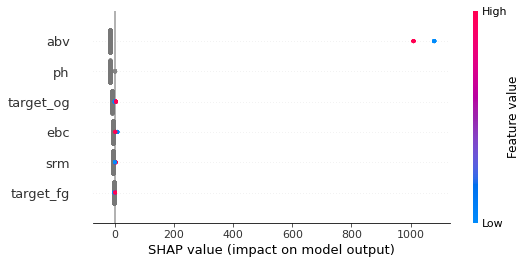

In [ ]:
shap_values = explainer(baseline.where(baseline.abv>20)[b_feat])
shap.plots.beeswarm(shap_values)

In [ ]:
(baseline.where(baseline.abv>20)['target_og']-baseline.where(baseline.abv>20)['target_fg']).mean()

100.57894736842105

Bebidas que apresentam um valor alto de volume de álcool também apresenta um IBU alto (tabela). Observa-se que estas bebidas apresentaram um diferença grande entre a gravidade inicial e final, mostrando que boa parte do açúcar do mosto foi fermentado, virando álcool. Do malte vem o açúcar para mistura, bem como os pigmentos para coloração da bebida (torra do grão, proteínas e açúcar). O açúcar no processo, quando aquecido, também pode gerar pigmentos para coloração da cerveja. Ou seja, uma cerveja escura também pode ter um amargor alto, quanto maior a quantidade de açúcar que vira álcool. 

Ou seja, o modelo considerar a variável `abv` com alto impacto para estes casos faz muito sentido, pois quanto maior a diferença entre a mistura inicial (og) e a final (fg), menor é o volume de cerveja final. Como o amargor (que vem do lúpulo) da cerveja é distribuído pelo volume dela, quanto menor este volume mais amarga a cerveja tende a ser.

In [ ]:
baseline.where(baseline.abv<20).describe()

abv    target_fg  ...          srm          ibu
count  2458.000000  2458.000000  ...  2458.000000  2458.000000
mean      7.569524  1015.587469  ...    34.347179    57.946705
std       3.093527    15.308518  ...    47.148476    37.946431
min       0.500000  1000.000000  ...     1.000000     0.000000
25%       5.200000  1010.000000  ...     8.000000    35.000000
50%       7.200000  1012.000000  ...    15.000000    50.000000
75%       9.000000  1015.000000  ...    40.000000    70.000000
max      18.300000  1125.000000  ...   305.000000   250.000000

[8 rows x 7 columns]

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


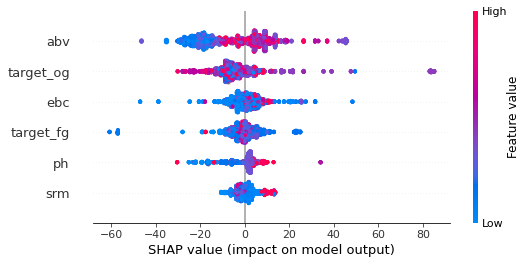

In [ ]:
shap_values = explainer(baseline.where(baseline.abv<20)[b_feat])
shap.plots.beeswarm(shap_values)

In [ ]:
(baseline.where(baseline.abv<20)['target_og']-baseline.where(baseline.abv<20)['target_fg']).mean()

51.398291293734744

In [ ]:
baseline.where(baseline.ibu>60).describe()

abv    target_fg  ...         srm          ibu
count  973.000000   973.000000  ...  973.000000   973.000000
mean     9.624995  1017.742035  ...   45.537321   110.843782
std      4.740033    16.684443  ...   56.851424   148.545376
min      3.500000  1003.000000  ...    6.000000    65.000000
25%      7.200000  1011.000000  ...    9.500000    70.000000
50%      8.200000  1013.000000  ...   16.000000    80.000000
75%     10.700000  1019.000000  ...   53.000000   100.000000
max     41.000000  1125.000000  ...  254.000000  1157.000000

[8 rows x 7 columns]

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


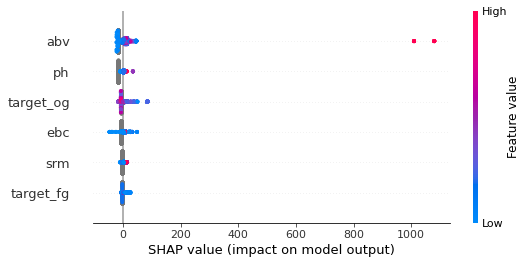

In [ ]:
shap_values = explainer(baseline.where(baseline.ibu>60)[b_feat])
shap.plots.beeswarm(shap_values)

In [ ]:
diff = (baseline.where(baseline.ibu>60)['target_og']-baseline.where(baseline.ibu>60)['target_fg'])
print (f"Média: {diff.mean()} Std {diff.std()} Min {diff.min()} Max {diff.max()}")

Média: 62.20863309352518 Std 35.1405562110949 Min -110.0 Max 140.0


> Quando avaliamos bebidas com IBU acima de 60 observa-se que o `pH` da água passa a ter uma alta relevância entre as variáveis do modelo. Também observa-se que as cervejas claras passam a ter um impacto negativo na saída do modelo. 

In [ ]:
shap_values = explainer(baseline[b_feat], y=baseline[b_target])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


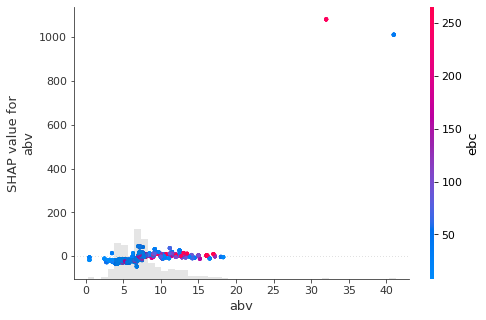

In [ ]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"abv"], color=shap_values[:,'ebc'])

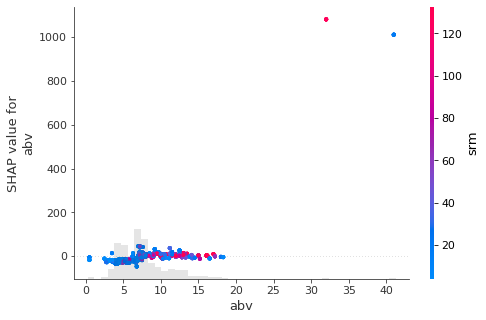

In [ ]:
shap.plots.scatter(shap_values[:,"abv"], color=shap_values[:,'srm'])

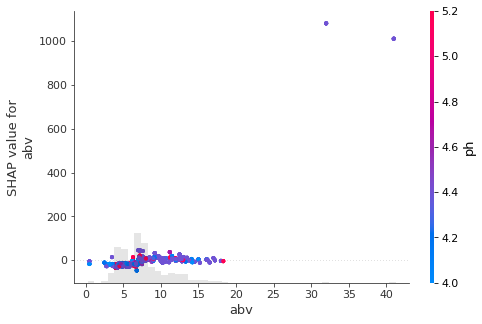

In [ ]:
shap.plots.scatter(shap_values[:,"abv"], color=shap_values[:,'ph'])

-------------------
-------------------

##### Explorando recursos

> Explorando recursos para melhorar o modelo.

###### V-treat

[Using vtreat with Regression Problems](https://github.com/WinVector/pyvtreat/blob/master/Examples/Regression/Regression.md)

In [ ]:
import vtreat

transform = vtreat.NumericOutcomeTreatment(outcome_name=target)
pd_vtreat = transform.fit_transform(pd_beers_clean[b_cols], pd_beers_clean[target])

In [ ]:
transform.score_frame_

variable orig_variable  ... default_threshold  recommended
0   ph_is_bad            ph  ...          0.166667         True
1  srm_is_bad           srm  ...          0.166667         True
2  ebc_is_bad           ebc  ...          0.166667         True
3          ph            ph  ...          0.083333        False
4   target_fg     target_fg  ...          0.083333         True
5         srm           srm  ...          0.083333         True
6         ebc           ebc  ...          0.083333         True
7         abv           abv  ...          0.083333         True
8   target_og     target_og  ...          0.083333         True

[9 rows x 11 columns]

V-treat remove o `pH` da água (pelos estudos eu tbm removeria). Ele cria variáveis indicativas de missing e as mantém como variáveis para o modelo.

In [ ]:
pd_vtreat.dtypes

ibu           float64
ph_is_bad     float64
srm_is_bad    float64
ebc_is_bad    float64
target_fg     float64
srm           float64
ebc           float64
abv           float64
target_og     float64
dtype: object

In [ ]:
vt_feat = pd_vtreat.columns[1:]
vt_feat

Index(['ph_is_bad', 'srm_is_bad', 'ebc_is_bad', 'target_fg', 'srm', 'ebc',
       'abv', 'target_og'],
      dtype='object')

> Como o modelo se comporta ?

In [ ]:
Vt_interm, Vt_test = train_test_split(pd_vtreat, test_size=0.20, random_state=42) # --/20
Vt_train, Vt_valid = train_test_split(Vt_interm, test_size=0.20, random_state=42) # 60/20

In [ ]:
xgb = xgboost.XGBRegressor()
xgb.fit(Vt_train[vt_feat], Vt_train[target])

avalia_ISE_OSE(Vt_train[vt_feat], Vt_train[target], Vt_valid[vt_feat], Vt_valid[target], xgb)

ISE
	R^2 1.000 	RMSE 1.514 
OSE
	R^2 1.000 	RMSE 1.789 

Test/Train 1.1819093574828543 -> 18.19093574828543 %


(0.9997583070461565,
 1.5140644019853773,
 0.9996820687795468,
 1.7894868845381993)

In [ ]:
evaluate_rmse_model(xgb, Vt_test[vt_feat], Vt_test[target])
evaluate_r2_model(xgb, Vt_test[vt_feat], Vt_test[target])

RMSE: 13.06914504516614 (7.064376532575669) [4.771957287622612, 34.68547201011661]
R^2: 0.8612994840645883 (0.23983468092403604) [-0.1241465974360656, 0.999623578524523]
